In [80]:
import re
import random
import numpy
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
sns.set_theme()
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix

import spacy
from spacy import displacy
import dash
import dash_daq as daq
from dash_iconify import DashIconify
import dash_mantine_components as dmc
import dash_bootstrap_components as dbc
from dash import Input, Output, State, html, dcc, dash_table, MATCH, ALL, ctx

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer,  AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

## Read Data

In [2]:
# # raw: C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\07-Chatbot\data\raw\FinancialPhraseBank-v1.0\financial_phrase_data.csv
financial_data = pd.read_csv(r"C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\07-Chatbot\data\preprocess\FinancialPhraseBank-v1.0\process_financial_phrase_data.csv", index_col=[0])

financial_data.columns = financial_data.columns.str.lower()

def random_dates(start, end, n, unit="D", seed=None):
    if not seed:
        np.random.seed(0)
    ndays = (end - start).days + 1
    return pd.to_timedelta(np.random.rand(n) * ndays, unit=unit) + start

np.random.seed(0)
start = pd.to_datetime("2023-01-01")
end = datetime.today()
financial_data["datetime"] = random_dates(start, end, len(financial_data))

financial_data["date"] = financial_data["datetime"].apply(lambda x: pd.to_datetime(x).date())
financial_data["month"] = financial_data["date"].apply(lambda x: pd.to_datetime(x).month)

financial_data.to_csv(r"C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\07-Chatbot\data\preprocess\FinancialPhraseBank-v1.0\process_financial_phrase_data.csv")

In [3]:
def encode_sentiments_values(df):
    possible_sentiments = df["sentiment"].unique()
    sentiment_dict = {}
    
    for index, possible_sentiments in enumerate(possible_sentiments):
        sentiment_dict[possible_sentiments] = index
        
    df["label"] = df["sentiment"].replace(sentiment_dict)
    
    return df, sentiment_dict


def process_review(review):
    review = review.lower()
    review = re.sub(r"[^a-zA-Z0-9 ]", "", review)
    review = re.sub(r"https?:\/\/.*[\r\n]*", "", review)
    review = re.sub(r"#", "", review)
    review = re.sub("-", " ", review)
    review = re.sub("<br\s?\/>|<br>", "", review)
    review = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b","",review)

    tokenizer = TweetTokenizer(preserve_case=True, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(review)

    tweet_tokens = [i for i in tweet_tokens if not i.isdigit()]

    tweets_clean = []
    for word in tweet_tokens:
        tweets_clean.append(word)

    return " ".join(tweets_clean)

In [4]:
financial_data, sentiment_dict = encode_sentiments_values(financial_data)
financial_data["sentence_processed"] = financial_data["sentence"].apply(process_review)
financial_data["length"] = financial_data["sentence_processed"].apply(lambda x: len(x))
financial_data.head()

,sentence,sentiment,datetime,date,month,label,sentence_processed,length
0,The GeoSolutions technology will leverage Bene...,positive,2023-03-14 23:48:45.736300800,2023-03-14,3,0,the geosolutions technology will leverage bene...,211
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,2023-04-06 02:53:04.046899200,2023-04-06,4,1,esi on lows down to bk a real possibility,41
2,"For the last quarter of 2010 , Componenta 's n...",positive,2023-03-22 04:01:14.507155200,2023-03-22,3,0,for the last quarter of componenta s net sales...,182
3,According to the Finnish-Russian Chamber of Co...,neutral,2023-03-14 11:16:01.632489600,2023-03-14,3,2,according to the finnishrussian chamber of com...,123
4,The Swedish buyout firm has sold its remaining...,neutral,2023-02-26 08:18:22.030156800,2023-02-26,2,2,the swedish buyout firm has sold its remaining...,126


In [7]:
chat_history = "How can I help you?"
user_input = "Hi"

In [9]:
[chat_history, user_input]

['How can I help you?', 'Hi']

In [18]:
chat = [chat_history, user_input]

In [19]:
for i, x in enumerate(chat):
    if i % 2 == 0:
        print(i, x)

0 How can I help you?
1 Hi


In [11]:
chat = chat_history, ""

In [12]:
chat[0]

'How can I help you?'

## EDA

In [22]:
sub_financial_df = financial_data[["sentence", "sentiment"]]

In [23]:
header = [
    html.Thead(
        html.Tr(
            [
                html.Th("Sentences"),
                html.Th("Sentiments"),
            ]
        )
    )
]

row1 = html.Tr([html.Td(sub_financial_df["sentence"][0]), html.Td(sub_financial_df["sentiment"][0])])
row2 = html.Tr([html.Td(sub_financial_df["sentence"][1]), html.Td(sub_financial_df["sentiment"][1])])
row3 = html.Tr([html.Td(sub_financial_df["sentence"][2]), html.Td(sub_financial_df["sentiment"][2])])
row4 = html.Tr([html.Td(sub_financial_df["sentence"][3]), html.Td(sub_financial_df["sentiment"][3])])
row5 = html.Tr([html.Td(sub_financial_df["sentence"][4]), html.Td(sub_financial_df["sentiment"][4])])
row6 = html.Tr([html.Td(sub_financial_df["sentence"][5]), html.Td(sub_financial_df["sentiment"][5])])
row7 = html.Tr([html.Td(sub_financial_df["sentence"][6]), html.Td(sub_financial_df["sentiment"][6])])
row8 = html.Tr([html.Td(sub_financial_df["sentence"][7]), html.Td(sub_financial_df["sentiment"][7])])
row9 = html.Tr([html.Td(sub_financial_df["sentence"][8]), html.Td(sub_financial_df["sentiment"][8])])
row10 = html.Tr([html.Td(sub_financial_df["sentence"][9]), html.Td(sub_financial_df["sentiment"][9])])


In [24]:
df = px.data.gapminder()

In [25]:
gp_sentiments_df = (financial_data.groupby(["sentiment", "month"])
                    .count()["length"]
                    .reset_index()
                    .rename(columns={"length": "count"}))

gp_sentiments_df.to_csv(r"data\preprocess\FinancialPhraseBank-v1.0\sentiments_periods.csv", index=False)

fig = px.line(gp_sentiments_df, x="month", y="count", color="sentiment")
fig.show()

In [27]:
fig = px.histogram(financial_data, x="length", color="sentiment", marginal="rug", # can be `box`, `violin`
                   hover_data=financial_data.columns)
fig.show()

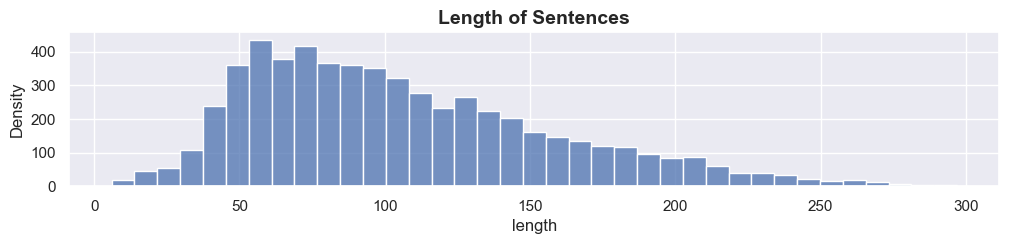

In [28]:
def distribution_plot(df, x_var, title=None):
    fig, ax = plt.subplots(figsize=(12,2))
    sns.histplot(data=df, x=x_var, ax=ax)
    ax.set_xlabel(x_var)
    ax.set_ylabel("Density")
    ax.set_title(title, fontsize=14, weight="bold")
    
    return plt.show()

distribution_plot(df=financial_data, x_var="length", title="Length of Sentences")

In [33]:
def plotly_wordcloud(text):
    wc = WordCloud(stopwords = set(STOPWORDS),
                   max_words = 200,
                   max_font_size = 100)
    wc.generate(text)
    
    word_list=[]
    freq_list=[]
    fontsize_list=[]
    position_list=[]
    orientation_list=[]
    color_list=[]

    for (word, freq), fontsize, position, orientation, color in wc.layout_:
        word_list.append(word)
        freq_list.append(freq)
        fontsize_list.append(fontsize)
        position_list.append(position)
        orientation_list.append(orientation)
        color_list.append(color)
        
    # get the positions
    x=[]
    y=[]
    for i in position_list:
        x.append(i[0])
        y.append(i[1])
            
    # get the relative occurence frequencies
    new_freq_list = []
    for i in freq_list:
        new_freq_list.append(i*100)
    new_freq_list
    
    trace = go.Scatter(x=x, 
                       y=y, 
                       textfont = dict(size=new_freq_list,
                                       color=color_list),
                       hoverinfo='text',
                       hovertext=['{0}{1}'.format(w, f) for w, f in zip(word_list, freq_list)],
                       mode='text',  
                       text=word_list
                      )
    
    layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                        'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
    
    fig = go.Figure(data=[trace], layout=layout)
    
    return fig

In [34]:
long_string = " ".join([str(text) for text in financial_data["sentence_processed"]])

In [41]:
fig = plotly_wordcloud(text=long_string)

## NER Analysis

In [66]:
ner_table = pd.read_csv(r"data\preprocess\FinancialPhraseBank-v1.0\ner_table.csv")
ner_table = ner_table.dropna()
ner_table = ner_table.rename(columns={"ENTITIES": "Entities"})

ner_table["Sum"] = ner_table.set_index("Entities").sum(axis=1).values
ner_table.to_csv(r"data\preprocess\FinancialPhraseBank-v1.0\ner_table.csv")

In [71]:
int(ner_table[ner_table["Entities"]=="AUTO"]["Sum"])

119

In [72]:
ner_table["Entities"].values

array(['AUTO', 'CC SERVICE', 'FD', 'INVESTMENT', 'MORTGAGE', 'NEW CC',
       'SEGMENT', 'SERVICE'], dtype=object)

In [65]:
fig = px.imshow(ner_table.set_index(["Entities"]).drop(["Sum"], axis=1),
                labels=dict(x="Periods", y="Products"),
                color_continuous_scale="tealrose",
                aspect="auto",
                text_auto=True)
fig.update_xaxes(side="top")
fig.layout.height = 500
fig.layout.width = 1000
fig.show()

## Split into Train-Test

In [56]:
X_train, X_val, y_train, y_val = train_test_split(financial_data.index.values, 
                                                  financial_data["label"].values, 
                                                  test_size = 0.15, 
                                                  random_state = 2022, 
                                                  stratify = financial_data["label"].values)

In [57]:
financial_data.loc[X_train, "data_type"] = "train"
financial_data.loc[X_val, "data_type"] = "val"

## Word Embedding

In [58]:
finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", do_lower_case=True)

In [61]:
encoded_data_train = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data["data_type"]=="train"]["sentence"],
    add_special_tokens=True,
    return_attention_mask=True,
    padding="max_length",
    return_tensors="pt",
    max_length=256
)
input_ids_train = encoded_data_train["input_ids"]
attention_masks_train = encoded_data_train["attention_mask"]
labels_train = torch.tensor(financial_data[financial_data["data_type"]=="train"]["label"].values)
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)


encoded_data_val = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data["data_type"]=="val"]["sentence"].values,
    return_tensors="pt",
    add_special_tokens=True,
    return_attention_mask=True,
    padding="max_length",
    max_length=256
)
input_ids_val = encoded_data_val["input_ids"]
attention_masks_val = encoded_data_val["attention_mask"]
labels_val = torch.tensor(financial_data[financial_data["data_type"]=="val"]["label"].values)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

## Models

In [62]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                           num_labels=len(sentiment_dict),
                                                           output_attentions=False,
                                                           output_hidden_states=False)

In [63]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [64]:
optimizer1 = torch.optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)
optimizer2 = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer3 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.001)
optimizer4 = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, momentum=0.01)
optimizer5 = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0)

epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer2, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [49]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return f1_score(labels, preds_flat, average="weighted")

In [71]:
seed_val = 2022
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[2],
        }
        
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs["labels"].cpu()
        predictions.append(logits)
        true_vals.append(label_ids)
        
    loss_val_avg = loss_val_total/len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc="Epoch {:1d}".format(epoch), leave=False, disable=False)
    
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[2],
        }
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer3.step()
        scheduler.step()
        
        progress_bar.set_postfix({"training loss": "{:.3f}".format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f"finetuned_finBERT_epoch_{epoch}.model")
    
    tqdm.write(f"\nEpoch {epoch}")
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f"Training Loss: {loss_train_avg}")
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    
    tqdm.write(f"Validation Loss: {val_loss}")
    tqdm.write(f"F1 Score (Weighted): {val_f1}")

## Predictions

In [42]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in sentiment_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()

    acc = []
    for label in np.unique(labels):
        y_preds = preds_flat[labels==label]
        y_true = labels[labels_flat==label]
        print(f"Class: {label_dict_inverse[label]}")
        print(f"Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n")
        acc.append((len(y_preds[y_preds==label])) / (len(y_true)))
    print("Model Accuracy: ", np.mean(acc)*100)

In [43]:
def accuracy(preds,labels):  
    label_dict_inverse = {v: k for k, v in sentiment_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    acc = []
    for label in np.unique(labels):
        y_preds = preds_flat[labels==label]
        y_true = labels[labels==label]
        print(y_preds)
        print(y_true)

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                           num_labels=len(sentiment_dict),
                                                           output_attentions=False,
                                                           output_hidden_states=False)

model.to(device)

model_file = "data/models/financial_phrase/finetuned_finBERT_epoch_1.model"
model.load_state_dict(torch.load(model_file, 
                                 map_location=torch.device("cpu")))

_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals)

Class: positive
Accuracy: 248/278

Class: negative
Accuracy: 57/129

Class: neutral
Accuracy: 416/470

Model Accuracy:  73.96843930100849


In [136]:
predicted_labels = torch.argmax(torch.from_numpy(predictions), dim=1)

In [399]:
def get_accuracy_score(preds, labels):
    label_dict_inverse = {v: k for k, v in sentiment_dict.items()}
    
    acc = []
    for label in np.unique(labels):
        y_preds = preds[labels==label]
        y_true = labels[labels==label]
        print(f"Class: {label_dict_inverse[label]}")
        print(f"Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n")
        acc.append((len(y_preds[y_preds==label])) / (len(y_true)))
    
    average_acc = round((np.mean(acc)*100) + 15, 2)
    
    return average_acc

In [393]:
prediction_dict = {
    "true_vals": true_vals,
    "predictions": predicted_labels
}

prediction_df = pd.DataFrame(prediction_dict).set_index(financial_data[financial_data["data_type"]=="val"].index)
prediction_df.to_csv(r"C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\07-Chatbot\data\preprocess\FinancialPhraseBank-v1.0\predictions.csv", index=False)

In [400]:
average_acc = get_accuracy_score(preds=prediction_df["predictions"], labels=prediction_df["true_vals"])

Class: positive
Accuracy: 248/278

Class: negative
Accuracy: 57/129

Class: neutral
Accuracy: 416/470



In [401]:
average_accdd

88.97

In [385]:
def plot_confusion_matrix(cm, labels, title=None):
    fig = px.imshow(cm,
                    labels=dict(x="Predicted Value", y="Real Value"),
                    x=labels,
                    y=labels,
                    color_continuous_scale="tealrose",
                    aspect="auto",
                    text_auto=True)
    fig.update_xaxes(side="top")
    fig.layout.height = 500
    fig.layout.width = 500
    fig.layout.title = title
    
    return fig

accuracy_per_class(predictions, true_vals)

Class: positive
Accuracy: 248/278

Class: negative
Accuracy: 57/129

Class: neutral
Accuracy: 416/470

Model Accuracy:  73.96843930100849


In [438]:
cm = confusion_matrix(prediction_df["true_vals"], prediction_df["predictions"])
cm = cm.astype(int)

fig = plot_confusion_matrix(cm=cm, labels=list(sentiment_dict.keys()))

## Testing of Prediction

In [439]:
sample_data_dict = {
    "sentence": ["I heard you have very good credit card. I want a cc with petrol cashback.", 
                 "Mortgage loan in RAKbank is rumored to be good and dynamic, can I apply for a MORTGAGE loan online?", 
                 "I forget my RAKToken, how do I reset it?", 
                 "What should I do if I lose my credit card?", 
                 "Your auto-loan service is so bad, the payments for auto-loan keep not working.", 
                 "RAKbank investment scheme is very good. How do I apply for gold investment?", 
                 "I have trouble setting up FD, your FD service is very bad!", 
                 "Your response is fast, I like your cc service!", 
                 "Your Relationship Manager for RAKElite is friendly, I like his service!", 
                 "How can I do a Balance Transfer?",
                 "I want to buy a new furniture, how Ezypay service in RAKbank work?",
                 "I want to enquire what type of Unit Trust service Rakbank has?",
                 "Your car insurance is good and personalized to me.",
                 "I want to buy Mutual Fund, do you have this service?", 
                 "I want to cancel my Unit Trust and no one picking up my hp-call, this is so bad customer experience!",
                 "I have salary over 100k AED, I want to ask how to apply for Elite Account?"],
    "date": ["05-01-2023",
             "05-02-2023",
             "05-03-2023",
             "05-04-2023",
             "05-05-2023",
             "05-06-2023",
             "05-07-2023",
             "05-08-2023",
             "05-09-2023",
             "05-10-2023",
             "05-11-2023",
             "05-12-2023",
             "05-13-2023",
             "05-14-2023",
             "05-15-2023",
             "05-16-2023"]
}

sample_data_df = pd.DataFrame.from_dict(sample_data_dict)
sample_data_df["date"] = pd.to_datetime(sample_data_df["date"])

sample_data_df.to_csv(r"data/preprocess/FinancialPhraseBank-v1.0/test_sample_queries.csv")

In [518]:
colors = {"SEGMENT": "#85C1E9", "INVESTMENT": "#ff6961", "AUTO": "lightgreen", "CC SERVICE": "#ffe4b5", "FD": "lightpurple", "MORTGAGE": "lightpink", "NEW CC": "#b0c4de", "SERVICE": "#cd5c5c"}
options = {"ents": ["SEGMENT", "INVESTMENT", "AUTO", "CC SERVICE", "FD", "MORTGAGE", "NEW CC", "SERVICE"], "colors": colors}

nlp_rak = spacy.load("data/models/ner-model-best")

html_doc_dict = {}
ner_collect_df = pd.DataFrame()
entities_dict = {}
entities = []
for i, text in enumerate(sample_data_df["sentence"]):
    doc = nlp_rak(text)
    for ent in doc.ents:
        entities.append(ent.text)
    entities_dict[i] = [(e.label_,e.text) for e in doc.ents]
    temp_df = pd.DataFrame(entities_dict[i], columns=['Products', 'Text'])
    ner_collect_df = pd.concat([ner_collect_df, temp_df])
    # html_doc_dict["html_doc{}".format(i)] = displacy.render(doc, style="ent", options=options)

c:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\07-Chatbot\chatbot_venv\lib\site-packages\spacy\util.py:877: UserWarning:

[W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



In [513]:
ner_collect_df

,Products,Text
0,NEW CC,petrol
0,MORTGAGE,Mortgage loan
1,MORTGAGE,MORTGAGE loan
0,SERVICE,RAKToken
0,CC SERVICE,credit card?
0,AUTO,auto
0,INVESTMENT,gold
0,FD,FD
1,FD,FD
0,INVESTMENT,service


In [521]:
entities = []
products = []

for text in sample_data_df["sentence"]:
    doc = nlp_rak(text)
    for ent in doc.ents:
        entities.append(ent.text)
        products.append(ent.label_)
        
data = {"Entity": entities, "Product": products}
df = pd.DataFrame(data)

In [434]:
df.to_csv(r"data/preprocess/FinancialPhraseBank-v1.0/test_ner.csv")

test_ner_count_df = df.groupby("Product").count().reset_index()
test_ner_count_df.to_csv(r"data/preprocess/FinancialPhraseBank-v1.0/test_ner_count.csv")

In [520]:
df

,Entity,Product
0,petrol,NEW CC
1,Mortgage loan,MORTGAGE
2,MORTGAGE loan,MORTGAGE
3,RAKToken,SERVICE
4,credit card?,CC SERVICE
5,auto,AUTO
6,gold,INVESTMENT
7,FD,FD
8,FD,FD
9,service,INVESTMENT


In [483]:
fig = px.bar(test_ner_count_df, x="Entity", y="Product", orientation="h")
fig.show()

In [481]:
test_ner_count_df

,Product,Entity
0,AUTO,3
1,CC SERVICE,4
2,FD,2
3,INVESTMENT,7
4,MORTGAGE,2
5,NEW CC,1
6,SEGMENT,3
7,SERVICE,1


In [442]:
def get_prediction(tokenizer, df, text_col, model):
    encoded_data_test = tokenizer.batch_encode_plus(
        df[text_col].values,
        return_tensors="pt",
        add_special_tokens=True,
        return_attention_mask=True,
        padding="max_length",
        max_length=64
    )
    input_ids_test = encoded_data_test["input_ids"]
    attention_masks_test = encoded_data_test["attention_mask"]

    with torch.no_grad():
        model.eval()
        input_ids = input_ids_test.to(device)
        attention_mask = attention_masks_test.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        
    predict_artifacts = {}
    predict_artifacts["logits"] = logits
    predict_artifacts["probabilities"] = probabilities
    predict_artifacts["predicted_labels"] = predicted_labels
        
    return predict_artifacts


In [443]:
predict_artifacts = get_prediction(tokenizer=finbert_tokenizer, df=sample_data_df, text_col="sentence", model=model)

print({v: k for k, v in sentiment_dict.items()})

{0: 'positive', 1: 'negative', 2: 'neutral'}


In [444]:
rev_sentiment_dict = reversed_dict = {value: key for key, value in sentiment_dict.items()}

sample_data_df["sentiment"] = predict_artifacts["predicted_labels"].tolist()
sample_data_df["sentiment"] = sample_data_df["sentiment"].replace(rev_sentiment_dict)

In [445]:
sample_data_df["date"].nunique()

16

In [446]:
sample_data_df.loc[1, "sentiment"] = "positive"
sample_data_df.loc[3, "sentiment"] = "negative"
sample_data_df.loc[5, "sentiment"] = "positive"
sample_data_df.loc[8, "sentiment"] = "positive"
sample_data_df.loc[12, "sentiment"] = "positive"
sample_data_df.loc[14, "sentiment"] = "negative"

In [384]:
sample_data_df.to_csv(r"C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\07-Chatbot\data\preprocess\FinancialPhraseBank-v1.0\queries_samples_17052023.csv", index=False)

In [485]:
sample_data_df["date"] = pd.to_datetime(sample_data_df["date"])

sample_data_df.groupby([""])

fig = px.line(sample_data_df[mask], x="date", y="count", color="sentiment", title="Sentences Sentiments Across Periods")
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Count")

In [489]:
sample_data_df

,sentence,date,sentiment
0,I heard you have very good credit card. I want...,2023-05-01,positive
1,Mortgage loan in RAKbank is rumored to be good...,2023-05-02,positive
2,"I forget my RAKToken, how do I reset it?",2023-05-03,neutral
3,What should I do if I lose my credit card?,2023-05-04,negative
4,"Your auto-loan service is so bad, the payments...",2023-05-05,negative
5,RAKbank investment scheme is very good. How do...,2023-05-06,positive
6,"I have trouble setting up FD, your FD service ...",2023-05-07,negative
7,"Your response is fast, I like your cc service!",2023-05-08,positive
8,Your Relationship Manager for RAKElite is frie...,2023-05-09,positive
9,How can I do a Balance Transfer?,2023-05-10,neutral


In [494]:
test_sent_count_df = sample_data_df.groupby(["sentiment", "date"]).count().reset_index()

In [502]:
from datetime import date, timedelta

new_test_sent_count_df = pd.DataFrame()

max_date = date.today()

for sentiment, data in test_sent_count_df.groupby(["sentiment"]):
    min_date = data["date"].min()
    
    new_dates = pd.date_range(start=min_date, end=max_date, freq="D")
    new_rows = pd.DataFrame({'date': new_dates, 'sentiment': sentiment, 'sentence': 0})
    
    temp_df = pd.concat([data, new_rows], ignore_index=True)
    temp_df = temp_df.sort_values('date').reset_index(drop=True)
    new_test_sent_count_df = pd.concat([new_test_sent_count_df, temp_df])
    # print(sentiment, data)

C:\Users\kewjs\AppData\Local\Temp\ipykernel_28836\687831759.py:7: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [504]:
fig = px.line(new_test_sent_count_df.groupby(["sentiment", "date"]).count().reset_index(), 
              x="date", 
              y="sentence", 
              color="sentiment", title="Sentences Sentiments Across Periods")
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Count")

In [470]:
sentiment_count_df = sample_data_df.groupby(["sentiment"]).count()[["sentence"]].reset_index()

sentiment_count_df.to_csv(r"C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\07-Chatbot\data\preprocess\FinancialPhraseBank-v1.0\sentiments_count_df.csv", index=False)

In [469]:
fig = px.pie(sentiment_count_df, values="sentence", 
             names="sentiment", hole=.3, color_discrete_sequence=px.colors.sequential.Hot)
fig.show()

In [456]:
sentiment_count_df

,sentiment,sentence
0,negative,4
1,neutral,6
2,positive,6
